

<i><b>Public AI</b></i>
<br>
# CIFAR-10을 이용한 ResNet 학습하기

### _Objective_
* CIFAR-10 데이터셋을 바탕으로, ResNet 학습시켜 보도록 하겠습니다. <br>
* ResNet 논문과 같이 유사한 결과가 나타나는 지 확인해보도록 하겠습니다. <br>


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


### 예제 데이터셋) CIFAR-10

ResNet에서는 `CIFAR-10` 데이터셋을 이용해 학습하고, 성능 평가에 대한 결과를 내놓았습니다. <br> 논문과 비슷하게 나올 수 있도록 모델을 학습시켜 보도록 하겠습니다.

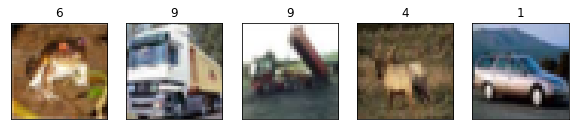

In [2]:
from tensorflow.keras.datasets import cifar10
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
train_y = train_y.flatten()
test_y = test_y.flatten()

# 이미지 시각화하기
fig = plt.figure(figsize=(10,3))
axes = fig.subplots(1, 5)

for ax, image, label in zip(axes, train_x, train_y):
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.imshow(image)
plt.show()

In [6]:
cifar10.load_data()

((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

<br>

# \[ 1. ResNet 구성하기 \]
---

ResNet 팀은 깊이에 따른 성능 변화를 추적하기 위해, CIFAR 데이터셋을 이용해 학습하였습니다. ResNet 팀이 진행했던 CIFAR-10 결과를 재현해보도록 하겠습니다.

여기서 보면 CIFAR 데이터셋을 처리하기 위해 진행했던 여러 수정사항들을 확인해 볼 수 있습니다.

1. 첫번째 레이어를 3x3 Convolution Layer로 변경하였습니다.
2. 총 2번의 Pooling을 거쳐서 32x32 -> 16x16 -> 8x8로 Feature map의 크기가 줄어듭니다.
3. 총 Layer의 갯수가 6n+2일 때, 각 Layer의 필터 갯수는 위의 규칙을 따릅니다.


![Imgur](https://i.imgur.com/wg5Or2h.png)

위의 규칙에 따라 Inference Network 내 Layer의 수를 따지면 아래와 같습니다.

#### 각 구간 별 Layer의 수 

|Output map size | 32x32 | 16x16 | 8x8 | 출력층 |
|---|---|---|---|---|
|resnet-20 | 7 | 6 | 6 | 1 |
|resnet-32 | 11 | 10 | 10 | 1 |
|resnet-44 | 15 | 14 | 14 | 1 |
|resnet-56 | 19 | 18 | 18 | 1 |
|resnet-110 | 37 | 36 | 36 | 1 |
|resnet-1202 | 401 | 400 | 400 | 1 |

이번 시간에서는 resnet-20을 구성하여 Test error가 8.75% 수준으로 나오는지 확인해 보도록 하겠습니다.

<br>

## 1. Inference Network 구성하기

|Output map size | 32x32 | 16x16 | 8x8 | 출력층 |
|---|---|---|---|---|
|resnet-20 | 7 | 6 | 6 | 1 |

이 규칙에 따라 구성해보도록 하겠습니다. 

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [5]:
def residual_block(input_layer, filters, strides=(1,1)):
    if input_layer.shape.as_list()[-1] != filters:
        # input_layer의 필터 갯수와 filters가 다르면, projection layer을 거침
        projection = Conv2D(
            filters, (1,1), strides=strides, padding='SAME')(input_layer)
    else:
        # 동일하면 바로 이어줌
        projection = input_layer
        
    conv = Conv2D(filters, (3,3), strides, padding='SAME')(input_layer)
    bn = BatchNormalization()(conv)
    act = ReLU()(bn)
    conv = Conv2D(filters, (3,3), padding='SAME')(act)
    bn = BatchNormalization()(conv)
    added = projection + bn
    out = tf.nn.relu(added)       

    return out        

In [7]:
input_shape = (32,32,3)
num_classes = 10

inputs = Input(input_shape, name='images')

rgb_mean = np.array([123.68, 116.779, 103.939], np.float32)
preprocessed = (inputs - rgb_mean) / 255.


for i in range(1,5):
    if i == 1:
        conv = Conv2D(16, (3,3), padding='SAME')(preprocessed)
    else:
        conv = residual_block(conv, 16)
    
for i in range(1,4):
    if i == 1:
        conv = residual_block(conv, 32, strides=(2,2))            
    else:
        conv = residual_block(conv, 32)

for i in range(1,4):
    if i == 1:
        conv = residual_block(conv, 64, strides=(2,2))
    else:
        conv = residual_block(conv, 64)

gap = GlobalAveragePooling2D()(conv)
pred = Dense(num_classes, activation='softmax')(gap)

model = Model(inputs, pred)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 32, 32, 3)]  0           images[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 32, 32, 3)]  0           tf_op_layer_sub_1[0][0]          
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 16)   448         tf_op_layer_truediv_1[0][0]      
____________________________________________________________________________________________

<br>

## 2. 학습에 관련된 부분들 구성하기

논문과 동일하게 구현하도록 하겠습니다.<br>

###  (1) Loss Function 구성하기

![Imgur](https://i.imgur.com/RkeK3yI.png)


In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy

loss = CategoricalCrossentropy()

### (2) Optimizer 구성하기

논문과 동일하게 Momentum Optimizer을 이용하도록 하겠습니다.

In [11]:
from tensorflow.keras.optimizers import SGD

optim = SGD(1e-1, 0.9)

### (3) Metric 구성하기


In [12]:
from tensorflow.keras.metrics import CategoricalAccuracy

acc_metric = CategoricalAccuracy()

### (4) 모델 컴파일 하기

In [13]:
model.compile(optim, 
              loss=loss,metrics=[acc_metric])

<br>

## 3. 모델 학습시키기


### (1) Callback 함수설정하기

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [15]:
reduce_lr = ReduceLROnPlateau(factor=1e-1, patience=1)
callbacks = [reduce_lr]

### (2) 모델 학습시키기

In [16]:
from tensorflow.keras.utils import to_categorical

onehot_y = to_categorical(train_y, num_classes)

In [ ]:
model.fit(train_x, onehot_y, 
          batch_size=64, 
          epochs=100, 
          callbacks=callbacks)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---